In [1]:
import os
import random
import json
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

import torch

torch.set_printoptions(precision=2,sci_mode=False)

from models.CLP import ContinuallyLearningPrototypes
from models.StreamingLDA import StreamingLDA
from models.NCM import NearestClassMean
from models.StreamingSoftmaxReplay import StreamingSoftmax
from models.OneVsRest import OneVsRest
from models.NaiveBayes import NaiveBayes
from models.Perceptron import Perceptron
from utils import get_backbone
from openloris.open_loris_utils import get_stream_data_loader, update_and_save_accuracies_semi_supervised, save_model_size,\
    update_and_save_accuracies

torch.cuda.empty_cache()

In [2]:
# General parameters for the experiment
dataset_name = "openloris"
images_dir = "/home/ehajizad/datasets/OpenLORIS"
save_dir_results = "/home/ehajizad/dev/CLP/results/"
arch='efficientnet_b0'
label_level = 'class'
batch_size = 64
seed = 10
num_classes = 40
test_order = None
device = 'cuda'

In [11]:
from torch.utils.data import TensorDataset, DataLoader
# For each random iteration of the experiment, multiple experiments with 
# different number of shots can be specified in a list. Single shot means single
# video from a given class. k=-1 means use all training videos

# Here we produce results for "low-shot instance" and "instance" learning settings
# corresponding to k=1 and k=-1

X_test = torch.load("../data/X_test.pt")
y_test = torch.load("../data/y_test.pt")

test_set = TensorDataset(X_test,y_test) # create your datset
test_loader = DataLoader(test_set, batch_size=batch_size,
                         num_workers=0, pin_memory=False) # create your dataloader


feature_size = X_test.shape[1]

### Experiment 1.1: Fully supervised online continual learning: low-shot instance

In [4]:
expt_name = "one_shot_results"
classifier = None
n_epoch = 1
k_shot_list = [1]
classifier_types = ['perceptron','fine_tune', 'nb', 'ovr', 'ncm', 'replay_2', 'replay_20', 'slda', 'clp' ]

# Setup before experiment starts

# Create results folter for this specific experiment
save_dir = save_dir_results + expt_name
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


# Three random seeds used here are same as Hayes at el. 2022
for k in k_shot_list:
    for s, seed in enumerate([10, 20, 30]):
        random.seed(seed) # set initial random seed
        accuracies = {'top1': [],'top5': []}
        exp_id = s # experiment id
        X_train = torch.load("../data/X_train_"+str(k)+"_shot_"+str(seed)+".pt")
        y_train = torch.load("../data/y_train_"+str(k)+"_shot_"+str(seed)+".pt")
        
        train_set = TensorDataset(X_train,y_train) # create your datset
        train_loader = DataLoader(train_set, batch_size=1,
                                num_workers=0, pin_memory=False, shuffle=False) # create your dataloader
        
        for c, classifier_type in enumerate(classifier_types):
            # We record only total accuracy and final model size
            
            if classifier_type == 'slda':
                classifier = StreamingLDA(feature_size, num_classes, backbone=None,
                                        shrinkage_param=1e-4, streaming_update_sigma=True)

            elif classifier_type == 'ncm':
                classifier = NearestClassMean(feature_size, num_classes, backbone=None)

            elif classifier_type == 'fine_tune':
                classifier = StreamingSoftmax(feature_size, num_classes, use_replay=False, backbone=None,
                                                lr=0.001, weight_decay=1e-5)

            elif classifier_type == 'replay_2':
                classifier = StreamingSoftmax(feature_size, num_classes, use_replay=True, backbone=None,
                                                lr=0.001, weight_decay=1e-5, replay_samples=50,
                                                max_buffer_size=80)
                
            elif classifier_type == 'replay_20':
                classifier = StreamingSoftmax(feature_size, num_classes, use_replay=True, backbone=None,
                                                lr=0.001, weight_decay=1e-5, replay_samples=50,
                                                max_buffer_size=800)

            elif classifier_type== 'nb':
                classifier = NaiveBayes(feature_size, num_classes, shrinkage_param=1e-4, backbone=None)

            elif classifier_type == 'ovr':
                classifier = OneVsRest(feature_size, num_classes, backbone=None)
            elif classifier_type == 'perceptron':
                classifier = Perceptron(feature_size, num_classes, backbone=None)

            elif classifier_type == 'clp':
                classifier = ContinuallyLearningPrototypes(feature_size,
                                                        n_protos=300,
                                                        num_classes=num_classes, 
                                                        backbone=None,
                                                        alpha_init=1,
                                                        sim_th_init=0.75,
                                                        n_wta=5,
                                                        k_hit=1,
                                                        k_miss=0.5,
                                                        adaptive_th=False,
                                                        learn_outliers=True,
                                                        device=device)

                    
            print('---------------------------------------------------------------------------')
            print('Beginning base streaming training of the classes...')
            print("Number of shots: " + str(k) )
            i = 0
            # X_train = torch.from_numpy(np.load("../data/X_train_"+str(k)+"_shot_"+str(seed)+".npy"))
            # y_train = torch.from_numpy(np.load("../data/y_train_"+str(k)+"_shot_"+str(seed)+".npy"))
            
            
            # Learn one sample at a time from the extracted features of current batch
            if classifier_type == 'clp':
                    for x, y in train_loader:
                    # fit model
                        classifier.fit(x.view(feature_size,), y.view(1, ))
            
            else:
                for x, y in train_loader:
                    # fit model
                    classifier.fit(x.view(feature_size,), y.view(1, ), i)
                    i+=1


            print('\nTesting on all classes using test data: ')
            # np.save("../results/learned_protos/5_shot_th_070_s_10.npy", classifier.prototypes_.cpu().numpy())
            
            # Evaluate on test data
            probas, y_test_init = classifier.evaluate_(test_loader)
            # probas, y_test_init = classifier.evaluate_(test_loader, return_sims=True)
            # probas, y_test_init = classifier.evaluate_(test_loader, return_probas=True, thresholded=False)
            # probas, y_test_init = classifier.evaluate_(test_loader, return_probas=False, thresholded=True)

            # Update and save accuracies
            update_and_save_accuracies(probas, y_test_init, save_dir, exp_id, accuracies)

            # # Get the model size for CLP by checking last allocated prototype id
            # final_model_size = classifier.next_alloc_id_

            # print("Model size: ", final_model_size)
            # print("N of errors: ", classifier.n_error)
            # print("N of outliers:", classifier.n_outlier)

            # # Save this also the "accuracies" dict
            # save_model_size(save_dir, exp_id, accuracies, final_model_size)

---------------------------------------------------------------------------
Beginning base streaming training of the classes...
Number of shots: 1


### Experiment 1.1: Fully supervised online continual learning: Instance (all training data used)

In [13]:
classifier = None
backbone, feature_size = get_backbone(arch, 'avg')
n_epoch = 1
classifier_types = ['perceptron','fine_tune', 'nb', 'ovr', 'ncm', 'replay_2', 'replay_20', 'slda', 'clp' ]
expt_name = "full_shot_results"
# Setup before experiment starts

# Create results folter for this specific experiment
save_dir = save_dir_results + expt_name
if not os.path.exists(save_dir):
    os.makedirs(save_dir)



# Three random seeds used here are same as Hayes at el. 2022
for s, seed in enumerate([10, 20, 30]):
    random.seed(seed) # set initial random seed
    accuracies = {'top1': [],'top5': []}
    exp_id = s # experiment id
    tr_loader = get_stream_data_loader(images_dir, True, batch_size=batch_size,
                                            ordering='instance',
                                            shuffle=False, augment=True, seed=seed, label_level='class',
                                            dataset=dataset_name)
    
    for c, classifier_type in enumerate(classifier_types):
        # We record only total accuracy and final model size
    
        
        if classifier_type == 'slda':
            classifier = StreamingLDA(feature_size, num_classes, backbone=backbone,
                                    shrinkage_param=1e-4, streaming_update_sigma=True)

        elif classifier_type == 'ncm':
            classifier = NearestClassMean(feature_size, num_classes, backbone=backbone)

        elif classifier_type == 'fine_tune':
            classifier = StreamingSoftmax(feature_size, num_classes, use_replay=False, backbone=backbone,
                                            lr=0.001, weight_decay=1e-5)

        elif classifier_type == 'replay_2':
            classifier = StreamingSoftmax(feature_size, num_classes, use_replay=True, backbone=backbone,
                                            lr=0.001, weight_decay=1e-5, replay_samples=50,
                                            max_buffer_size=80)
            
        elif classifier_type == 'replay_20':
            classifier = StreamingSoftmax(feature_size, num_classes, use_replay=True, backbone=backbone,
                                            lr=0.001, weight_decay=1e-5, replay_samples=50,
                                            max_buffer_size=800)

        elif classifier_type== 'nb':
            classifier = NaiveBayes(feature_size, num_classes, shrinkage_param=1e-4, backbone=backbone)

        elif classifier_type == 'ovr':
            classifier = OneVsRest(feature_size, num_classes, backbone=backbone)
        elif classifier_type == 'perceptron':
            classifier = Perceptron(feature_size, num_classes, backbone=backbone)

        elif classifier_type == 'clp':
            classifier = ContinuallyLearningPrototypes(feature_size,
                                                    n_protos=6000,
                                                    num_classes=num_classes, 
                                                    backbone=backbone,
                                                    alpha_init=1,
                                                    sim_th_init=0.75,
                                                    n_wta=5,
                                                    k_hit=1,
                                                    k_miss=0.5,
                                                    adaptive_th=False,
                                                    learn_outliers=True,
                                                    device=device)

                
        print('---------------------------------------------------------------------------')
        print('Beginning base streaming training of the classes...')
        print("Classifier type: ", classifier_type)
        print("Number of shots: FULL"  )
        i = 0
        # X_train = torch.from_numpy(np.load("../data/X_train_"+str(k)+"_shot_"+str(seed)+".npy"))
        # y_train = torch.from_numpy(np.load("../data/y_train_"+str(k)+"_shot_"+str(seed)+".npy"))
        for batch_ix, (batch_x, batch_y) in enumerate(tr_loader):
            if batch_ix % 500 == 0:
                print(batch_ix)
        # Extract features for current batch
            batch_x_feat = classifier.backbone(batch_x.to(device)).detach()

            # Learn one sample at a time from the extracted features of current batch
            for x, y in zip(batch_x_feat, batch_y):
                if classifier_type == 'clp':
                    # fit model
                    classifier.fit(x, y.view(1, ))
                else:
                    classifier.fit(x, y.view(1, ), torch.tensor(i).long())
                    i += 1
        
        classifier.backbone=None

        print('\nTesting on all classes using test data: ')
        # np.save("../results/learned_protos/5_shot_th_070_s_10.npy", classifier.prototypes_.cpu().numpy())
        
        # Evaluate on test data
        probas, y_test_init = classifier.evaluate_(test_loader)
        # probas, y_test_init = classifier.evaluate_(test_loader, return_sims=True)
        # probas, y_test_init = classifier.evaluate_(test_loader, return_probas=True, thresholded=False)
        # probas, y_test_init = classifier.evaluate_(test_loader, return_probas=False, thresholded=True)

        # Update and save accuracies
        update_and_save_accuracies(probas, y_test_init, save_dir, exp_id, accuracies)

        # # Get the model size for CLP by checking last allocated prototype id
        # final_model_size = classifier.next_alloc_id_

        # print("Model size: ", final_model_size)
        # print("N of errors: ", classifier.n_error)
        # print("N of outliers:", classifier.n_outlier)

        # # Save this also the "accuracies" dict
        # save_model_size(save_dir, exp_id, accuracies, final_model_size)

/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


---------------------------------------------------------------------------
Beginning base streaming training of the classes...
Classifier type:  clp
Number of shots: FULL
0
500
1000
1500

Testing on all classes using test data: 

Testing on 53295 images.

Index: 0 -- top1=99.16% -- top5=100.00%
---------------------------------------------------------------------------
Beginning base streaming training of the classes...
Classifier type:  clp
Number of shots: FULL
0
500
1000
1500

Testing on all classes using test data: 

Testing on 53295 images.

Index: 1 -- top1=99.13% -- top5=100.00%
---------------------------------------------------------------------------
Beginning base streaming training of the classes...
Classifier type:  clp
Number of shots: FULL
0
500
1000
1500

Testing on all classes using test data: 

Testing on 53295 images.

Index: 2 -- top1=99.21% -- top5=100.00%


In [ ]:
# Read results from json files for this experiment
results = [[],[]]
expt_names = ["full_shot_results", "one_shot_results"]
for e, expt_name in enumerate(expt_names):
    for exp_id in range(3):
        save_dir = save_dir_results + expt_name
        results_dict = defaultdict(dict)

        results_file = os.path.join(save_dir, "accuracies_index_" + str(exp_id)+".json")
        with open(results_file, 'r') as f:
            d = json.load(f)
            keysList = list(d.keys()) 
            for key in keysList:
                if key == 'top1':
                    results[e].append(d[key])
                    
results = np.array(results)

In [ ]:
print(np.mean(results, axis=1).round(2))
print(np.std(results, axis=1).round(2))

[[94.05 95.65 77.71 73.85 85.88 96.94 97.6  98.74 99.17]
 [27.76 22.74 42.4  44.77 51.77 49.78 53.19 47.23 54.12]]
[[0.51 0.54 0.02 0.01 0.01 0.07 0.11 0.01 0.03]
 [4.66 0.65 4.91 2.32 2.58 2.23 3.49 1.43 2.81]]


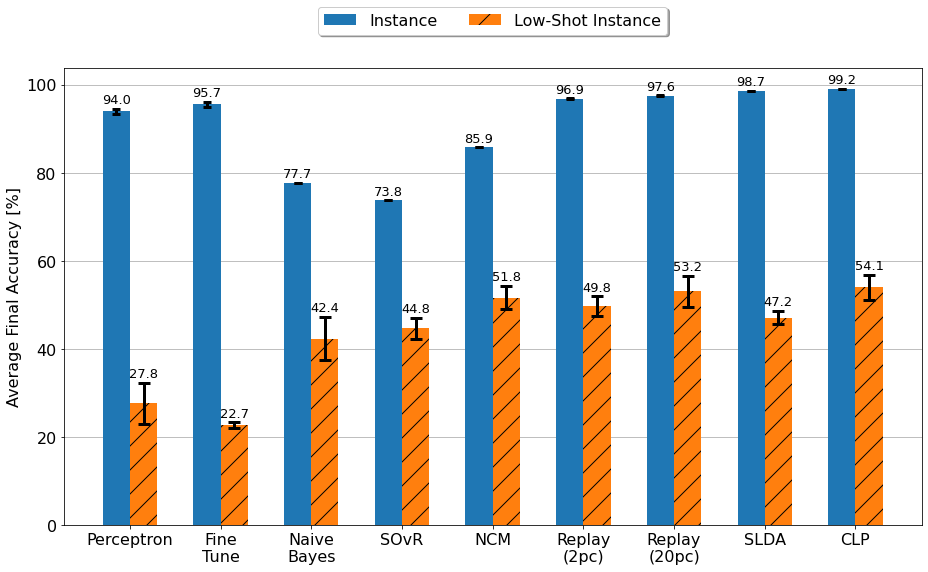

In [10]:
pretty_names = ['Perceptron', 'Fine\nTune', 'Naive\nBayes', 'SOvR', 'NCM',
                        'Replay\n(2pc)', 'Replay\n(20pc)', 'SLDA', 'CLP']

colors = ['#D81B60', '#648FFF']

save_dir_figures = "/home/ehajizad/dev/CLP-Embedded-CL/images/"

plt.rcParams['pdf.fonttype'] = 42  # Ensure that the font is embedded as Type 1
plt.rcParams['ps.fonttype'] = 42

labels_orig = range(len(pretty_names))
labels = []
for l in labels_orig:
    labels.append(pretty_names[l])

# full_ins_mean = np.mean(results[0,:], axis=0)
# full_ins_std = np.std(results[0,:], axis=0)
# low_ins_mean = np.mean(results[1,:], axis=0)
# low_ins_std = np.std(results[1,:], axis=0)

full_ins_mean = results[0,0,:]
full_ins_std = results[1,0,:]
low_ins_mean = results[0,1,:]
low_ins_std = results[1,1,:]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
rects1 = plt.bar(x - width / 2, full_ins_mean, width, label='Instance', alpha=1.0,
                 yerr=full_ins_std, capsize=4, error_kw=dict(lw=3, capthick=3,))
rects2 = plt.bar(x + width / 2, low_ins_mean, width, label='Low-Shot Instance',
                 alpha=1.0, yerr=low_ins_std, capsize=6, hatch='/', error_kw=dict(lw=3, capthick=3,))

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Average Final Accuracy [%]', fontsize=16)
plt.xticks(x, labels, fontsize=16)
plt.yticks(fontsize=16)
plt.ylim([0, 104])
ax.legend(["Instance", "Low-Shot Instance"], loc='upper center',
          bbox_to_anchor=(0.5, 1.15),
          ncol=2, fancybox=True, shadow=True, fontsize=16)

ax.bar_label(rects1, padding=2, fmt='%.1f', fontsize=13)
ax.bar_label(rects2, padding=2, fmt='%.1f', fontsize=13)

fig.tight_layout()
ax.set_axisbelow(True)
ax.yaxis.grid(True)

plt.show()

save_name = 'final_full_supervised_acc_comparison_chart'
if save_dir_figures is not None:
    fig.savefig(os.path.join(save_dir_figures, save_name + '.pdf'), bbox_inches="tight", format='pdf', dpi=600)